In [68]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


### Importing the data


In [75]:
file_path = 'Data.xlsx'
sheet_name = '2 - Data assignment'
data = pd.read_excel(file_path, sheet_name=sheet_name)


### Our raw data looks like this:

In [76]:
data.head()

,scan_date,product_id_mp,leaf_categ_name,title,price,description,brand,price_usd,condition,item_location,seller_feedback,buying_options,classification
0,2023-08-27,115480721726,"Clothing, Shoes & Accessories:Men:Men's Clothi...",Halloween Sexy Trick or Treat Graphic Sneaker ...,USD 22.99,Men Graphic Tee We Print on Pro Club Shaka and...,Jordan,22.99,New with tags,US,99,FIXED_PRICE,FalsePositive
1,2023-05-04,115738760184,"Clothing, Shoes & Accessories:Men:Men's Clothi...",420 Smoking Tee Shirt To Match Jordan 4 Pine S...,USD 20.99,Mens Tee Shirt Small -7x Shipping Information ...,Jordan,20.99,New with tags,US,98,FIXED_PRICE,FalsePositive
2,2023-05-07,115796912690,"Clothing, Shoes & Accessories:Men:Men's Clothi...",True Legends Never Die Sneaker Tee Shirt To Ma...,USD 20.59,We Thank You for Shopping With Us We are The U...,Jordan,20.59,New without tags,US,98,FIXED_PRICE,FalsePositive
3,2023-05-19,115808223230,"Clothing, Shoes & Accessories:Men:Men's Shoes:...",Jordan 4 Retro Thunder GS 7y,USD 190.00,Brand new with box in good condition. Has some...,Jordan,190.00,New with box,US,100,BEST_OFFER_FIXED_PRICE,FalsePositive
4,2023-06-04,115822886451,"Clothing, Shoes & Accessories:Men:Men's Shoes:...",Air Jordan 1 Retro Low OG SP Travis Scott Oliv...,USD 900.00,Brand new Air Jordan 1 Retro Low OG SP Travis ...,Jordan,900.00,New with box,US,99,FIXED_PRICE,FalsePositive


### Checking the data Representation 

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30434 entries, 0 to 30433
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   scan_date        30434 non-null  datetime64[ns]
 1   product_id_mp    30434 non-null  int64         
 2   leaf_categ_name  30434 non-null  object        
 3   title            30434 non-null  object        
 4   price            30434 non-null  object        
 5   description      29916 non-null  object        
 6   brand            30434 non-null  object        
 7   price_usd        30434 non-null  float64       
 8   condition        30434 non-null  object        
 9   item_location    30431 non-null  object        
 10  seller_feedback  30434 non-null  int64         
 11  buying_options   30434 non-null  object        
 12  classification   30434 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(9)
memory usage: 3.0+ MB


### The following plot shows us the distribution of target class in the data set

<Axes: >

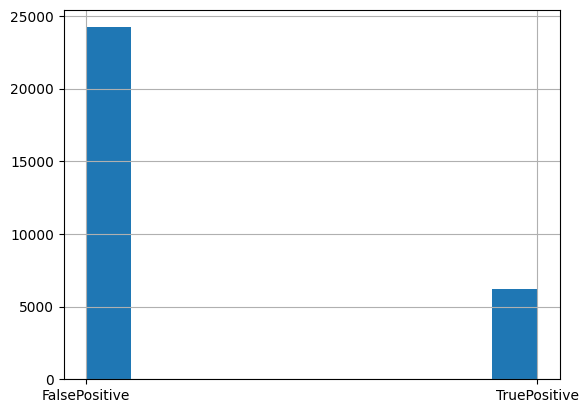

In [78]:
data['classification'].hist()

### Pre-processing the data.
#### scan_date, price and product_id_mp are irrelevat to us. The scan date can not teach us anything about future instances, the price is already shown in price_usd (where it is also normalised) and product_id_mp is unique to each instance.
#### In addition, for conveniency, we'll replace  FalsePositive with False, TruePositive with True, round price_usd and divide it to bins

In [39]:
data.dropna(inplace=True)
data = data.drop(columns=['price','product_id_mp','scan_date'])
data = data.replace('FalsePositive', False)
data = data.replace('TruePositive', True)
data['price_usd'] = data['price_usd'].round(2)
data['seller_feedback'] = data['seller_feedback']//10
num_bins = 7
l = ['1','2','3','4','5','6','7']
data['price_usd'] = pd.qcut(data['price_usd'], q=num_bins, labels=l, duplicates='drop')

data.head()


,leaf_categ_name,title,description,brand,price_usd,condition,item_location,seller_feedback,buying_options,classification
0,"Clothing, Shoes & Accessories:Men:Men's Clothi...",Halloween Sexy Trick or Treat Graphic Sneaker ...,Men Graphic Tee We Print on Pro Club Shaka and...,Jordan,1,New with tags,US,9,FIXED_PRICE,False
1,"Clothing, Shoes & Accessories:Men:Men's Clothi...",420 Smoking Tee Shirt To Match Jordan 4 Pine S...,Mens Tee Shirt Small -7x Shipping Information ...,Jordan,1,New with tags,US,9,FIXED_PRICE,False
2,"Clothing, Shoes & Accessories:Men:Men's Clothi...",True Legends Never Die Sneaker Tee Shirt To Ma...,We Thank You for Shopping With Us We are The U...,Jordan,1,New without tags,US,9,FIXED_PRICE,False
3,"Clothing, Shoes & Accessories:Men:Men's Shoes:...",Jordan 4 Retro Thunder GS 7y,Brand new with box in good condition. Has some...,Jordan,4,New with box,US,10,BEST_OFFER_FIXED_PRICE,False
4,"Clothing, Shoes & Accessories:Men:Men's Shoes:...",Air Jordan 1 Retro Low OG SP Travis Scott Oliv...,Brand new Air Jordan 1 Retro Low OG SP Travis ...,Jordan,7,New with box,US,9,FIXED_PRICE,False


### Computed the entropy of each feature. Didn't really use it eventually. The entropy of a feature tells us how much it can "teach" us about the target class. 0 being the most informative (divides the data perfectly with regards to class target. 1 being zero information.

In [40]:

def calculate_entropy(df, column_name, target_class='classification'):

    unique_values = df[column_name].unique()
    entropy = 0
    total_samples = len(df)
    for value in unique_values:
        p_value = len(df[df[column_name] == value]) / total_samples
        conditional_probs = df[df[column_name] == value][target_class].value_counts(normalize=True)
        value_entropy = 0
        for prob in conditional_probs:
            value_entropy -= prob * np.log2(prob)
        entropy += p_value * value_entropy
    
    return entropy


In [41]:
ls = ['leaf_categ_name','brand','price_usd','condition','item_location','seller_feedback','buying_options']
for column in ls:
    print('Entropy of',column,': ',calculate_entropy(data,column))

Entropy of leaf_categ_name :  0.7175725823738349
Entropy of brand :  0.7265143794051715
Entropy of price_usd :  0.7178256164456631
Entropy of condition :  0.7185618792792229
Entropy of item_location :  0.7089054220355829
Entropy of seller_feedback :  0.6930279916275655
Entropy of buying_options :  0.720997089319112


### Now I am going to build a desicion tree using sklearn. The library of sklearn takes care of everything. All i need to do is pre-process the data a little more. the algorithem only takes integers as input, Therefore I will convert each column to a numeric value. The columns of title, description and category name, I will leave aside, since it is hard to encode them to a numeric value

In [42]:
X = data[['leaf_categ_name','brand','price_usd','condition','item_location','seller_feedback','buying_options']]
y = data['classification']


def encode_categorical_columns(df):

    encoding_maps = {}
    encoded_df = pd.DataFrame()
    
    for column in df.columns:
        if df[column].dtype == 'object':
            categories = df[column].unique()
            encoding_map = {category: index for index, category in enumerate(categories)}
            encoding_maps[column] = encoding_map
            encoded_column = df[column].map(encoding_map)
            encoded_df[column] = encoded_column
        else:
            encoded_df[column] = df[column]
    
    return encoded_df, encoding_maps

In [43]:
encoded_df, encoding_maps = encode_categorical_columns(X)

### This is how the algorithms input looks like:

In [44]:
encoded_df

,leaf_categ_name,brand,price_usd,condition,item_location,seller_feedback,buying_options
0,0,0,1,0,0,9,0
1,0,0,1,0,0,9,0
2,0,0,1,1,0,9,0
3,1,0,4,2,0,10,1
4,1,0,7,2,0,9,0
...,...,...,...,...,...,...,...
30429,2,0,1,2,1,10,3
30430,2,0,3,2,1,10,0
30431,1,0,7,2,0,10,1
30432,1,0,3,5,44,0,4


### And that is the encodings dictionary

In [45]:
encoding_maps

{'leaf_categ_name': {"Clothing, Shoes & Accessories:Men:Men's Clothing:Shirts:T-Shirts": 0,
  "Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes": 1,
  "Clothes, Shoes & Accessories:Men:Men's Shoes:Trainers": 2,
  "Clothing, Shoes & Accessories:Men:Men's Clothing:Activewear:Hoodies & Sweatshirts": 3,
  "Clothing, Shoes & Accessories:Women:Women's Shoes:Athletic Shoes": 4,
  'Kleding en accessoires:Heren: kleding, accessoires:Heren: schoenen:Sportschoenen': 5,
  'Kleidung & Accessoires:Herren:Herrenmode:Shirts & Hemden:T-Shirts': 6,
  "Clothes, Shoes & Accessories:Women:Women's Shoes:Trainers": 7,
  "Clothing, Shoes & Accessories:Men:Men's Clothing:Socks": 8,
  "Clothes, Shoes & Accessories:Men:Men's Clothing:Shirts & Tops:T-Shirts": 9,
  "Clothing, Shoes & Accessories:Men:Men's Clothing:Activewear:Activewear Shorts": 10,
  "Clothing, Shoes & Accessories:Men:Men's Clothing:Shorts": 11,
  'Sports Mem, Cards & Fan Shop:Fan Apparel & Souvenirs:Hockey-NHL': 12,
  "Clothes, Shoes 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7949189369881331
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.97      0.88      4760
        True       0.49      0.10      0.17      1223

    accuracy                           0.79      5983
   macro avg       0.65      0.54      0.53      5983
weighted avg       0.74      0.79      0.74      5983

Confusion Matrix:
[[4630  130]
 [1097  126]]


### This is our desicion tree. As you can see it scored almost 80% accuracy on the test set. All that with relaying of course on a small set of features as I showed earlier. 
### Our confusion matrix, shows us how well we did. Upper left being TP and clock wise FP, TN, FN
### This is phisically how the tree looks like. Each node stands for a feature the algorithm chose to split the data by, untill it reached a point the group is classified all as one value, either it reched the maximum depth (3) then it classified it by the Majority of that group
### As you can see in the plot below, the features that the algo considered the most are: seller feedback, price, location and condition.

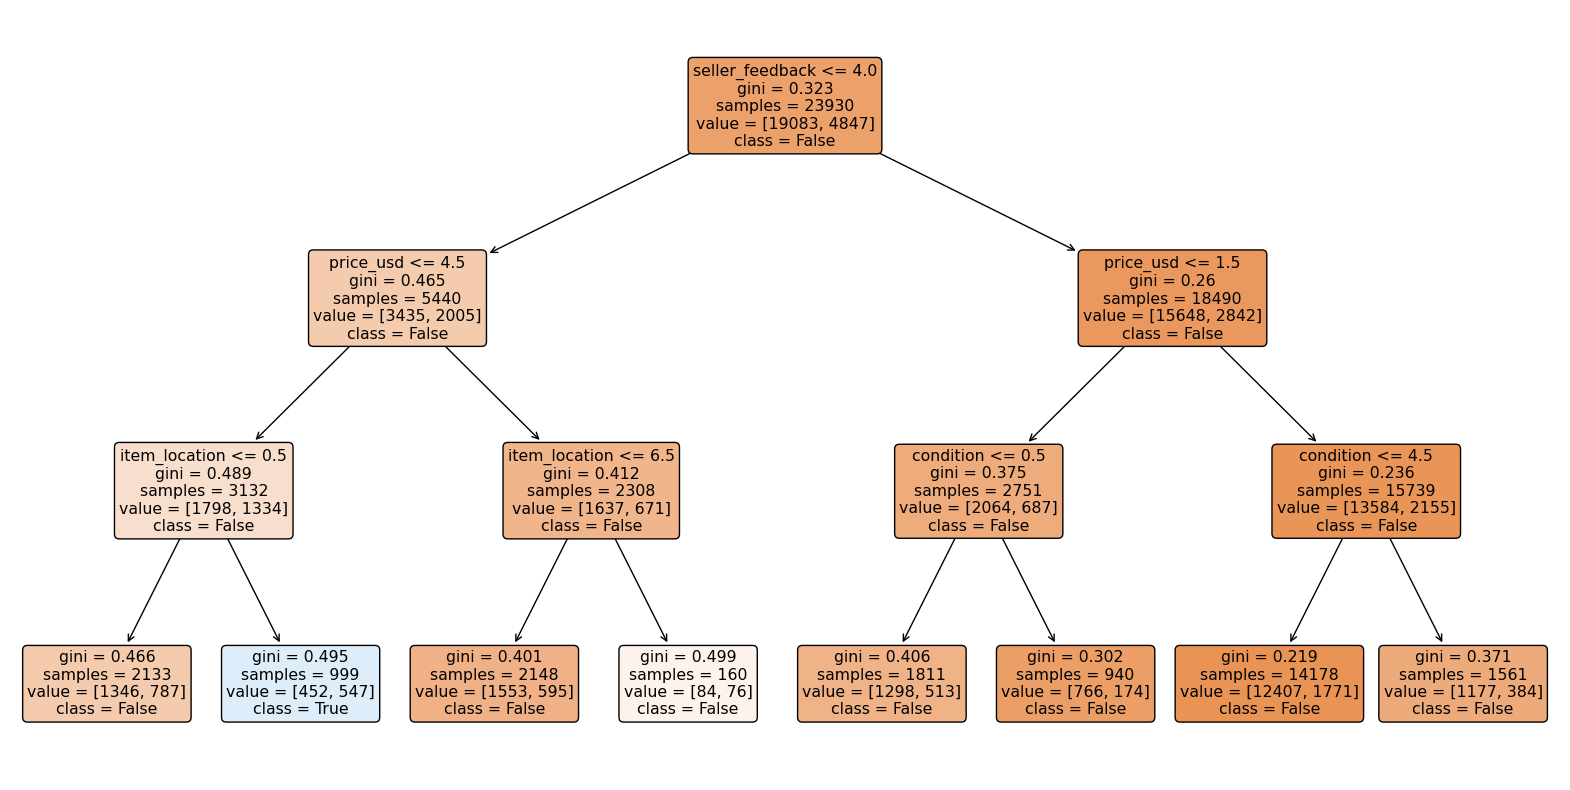

In [47]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns.tolist(), class_names=['False', 'True'], rounded=True)
plt.show()

### The plot shows us the "path" of instances that were classified as true. We can see that the majority of true instances have a seller feedback lower than 40, in the price range 2-4, and located in the us.

### Now I would like too try another approach. My decision tree took in consideration only the features that were easy to numericlly encode, not for example the description or title

### This approach will try and classify from the other end. We will try and get the key words of each target class, and see if we can classify by them

In [71]:
X_words = data[['leaf_categ_name','description','title']]
y = data['classification']
X_train, X_test, y_train, y_test = train_test_split(X_words, y, test_size=0.2, random_state=10)
X_test['description'] = X_test['description'].astype(str)
X_test['title'] = X_test['title'].astype(str)
X_test['leaf_categ_name'] = X_test['leaf_categ_name'].astype(str)

### First let's extract the common words of the features description and title, This function will return two dictionaries with descending order of the most common words in the train set divided to true and false classifications. 

In [72]:

stop_words = set(stopwords.words('english'))

def common_words(x_train, y_train):
    train_positive_words = []
    train_negative_words = []

    for description, title,category, label in zip(x_train['description'], x_train['title'],x_train['leaf_categ_name'] ,y_train):
        if isinstance(description, str) and label:
            words_desc = word_tokenize(description.lower())
            words_title = word_tokenize(title.lower())
            words_ctg = word_tokenize(category.lower())
            words_desc = [word for word in words_desc if word not in stop_words]
            words_title = [word for word in words_title if word not in stop_words]
            words_ctg = [word for word in words_ctg if word not in stop_words]
            train_positive_words.extend(words_desc + words_title+words_ctg)
        elif isinstance(description, str) and not label:
            words_desc = word_tokenize(description.lower())
            words_title = word_tokenize(title.lower())
            words_ctg = word_tokenize(category.lower())
            words_desc = [word for word in words_desc if word not in stop_words]
            words_title = [word for word in words_title if word not in stop_words]
            words_ctg = [word for word in words_ctg if word not in stop_words]
            train_negative_words.extend(words_desc + words_title+words_ctg)

    positive_word_counts = Counter(train_positive_words)
    negative_word_counts = Counter(train_negative_words)

    most_common_positive = positive_word_counts.most_common(20000)
    most_common_negative = negative_word_counts.most_common(20000)

    dic_positive = {keyword: count for keyword, count in most_common_positive}
    dic_negative = {keyword: count for keyword, count in most_common_negative}

    return dic_positive, dic_negative



In [73]:
dic_true, dic_false = common_words(X_train, y_train)

print(dic_true)
print(dic_false)

{',': 31204, '.': 24632, ':': 20247, 'shoes': 12455, 'size': 10984, 'men': 10255, 'jordan': 8932, 'please': 7294, 'us': 7146, '&': 6557, "'s": 6496, '-': 5951, 'shipping': 5721, ';': 5300, 'retro': 5159, 'accessories': 4835, 'clothing': 4491, 'amp': 4472, '*': 4459, '1': 4110, 'air': 3453, 'products': 3394, 'business': 3371, 'days': 3092, ')': 3009, '(': 3004, '4': 2875, 'athletic': 2785, 'payment': 2782, 'new': 2540, '!': 2360, 'order': 2345, 'contact': 2277, 'return': 2227, 'high': 2185, "''": 2131, 'black': 2096, 'og': 2030, '5': 1987, 'accept': 1921, 'nike': 1848, 'items': 1845, '10': 1828, 'made': 1774, 'low': 1738, 't-shirt': 1717, 'uk': 1706, 'delivery': 1671, 'time': 1644, 'mid': 1585, 'make': 1567, 'color': 1561, 'may': 1552, 'paypal': 1526, 'shirts': 1502, 'box': 1500, '%': 1488, 'shirt': 1479, 't-shirts': 1463, 'trainers': 1457, 'feedback': 1455, 'address': 1433, 'buy': 1404, 'item': 1388, 'due': 1388, 'women': 1378, 'print': 1369, '100': 1349, '3': 1342, 'x': 1340, 'send': 

### Now I would like to keep only the words that are not in the intersection of the two groups

In [57]:

words_true = set(dic_true.keys())
words_false = set(dic_false.keys())

common_words_true_only = words_true - words_false
common_words_false_only = words_false - words_true

print("Words common in dic_true but not in dic_false:", common_words_true_only)
print("Words common in dic_false but not in dic_true:", common_words_false_only)

Words common in dic_true but not in dic_false: {"'unc'-", 'cpfm', '23.7', '/ogâ€™s', 'ryobi', 'available-', 'f.r.i.e.n.d', '553558-052', 'boxy', '657', 'remind', 'mixing', 'bw0549', '607', 'heartwarming', 'ancient', '43.5', 'appritiate', '271', 'stacking', 'autorizada', 'bush', 'chi-town', 'vx', 'âœ…âœˆï¸\x8f', 'bist', 'anagonye', 'mashed', 'absolutes', 'boxâš', 'peso', '9/30', 'uk6â\x9dœ', 'long-sleeved', '212', 'powers', 'solemates', 'nger', 'sweden', 'eur-', 'inputting', 'authenticâ€™', 'r3pâœ…', '07/20/19', 'shammgod', '553558040', 'slighty', 'floods', 'backpack', 'jr', 'wir', 'restocks', '.us', 'â£300+', 'offers-', 'ceremoniesâ€', 'semelle', 'vereint', 'r3plica', 'sacrifier', 'eur46', 'damagelittle', 'sweatshirt/hoodie', 'us:10', '-44', '1price-180dm', 'abit', 'laundered', 'fit/tubular', 'butt', 'donâ´t', 'hordan', 'ab', '7-14days', 'issuerâ€™s', 'dc1788-029', 'woman.this', 'ogdesigner', 'highly-anticipated', 'kujhsede', 'disfigured', 'preorders', 'inhouse', 'â€œcourt', 'consist',

### Now with this simple model we will classify the test set. For each instance we will count the appearences of words within one of these two groups, and classify it as the class it had more words in the intersection. default (0 words) will be classified as false as chances are a given instance will be false.

In [60]:
def predict_classification(x_test, common_words_true_only, common_words_false_only):
    y_pred = []

    for description, title,category in zip(x_test['description'], x_test['title'],x_test['leaf_categ_name']):
        words_desc = word_tokenize(description.lower())
        words_title = word_tokenize(title.lower())
        words_ctg = word_tokenize(category.lower())
        words_desc = set([word for word in words_desc if word not in stop_words])
        words_title = set([word for word in words_title if word not in stop_words])
        words_ctg = set([word for word in words_ctg if word not in stop_words])
        

        count_true_desc = len(words_desc & common_words_true_only)
        count_false_desc = len(words_desc & common_words_false_only)
        count_true_title = len(words_title & common_words_true_only)
        count_false_title = len(words_title & common_words_false_only)
        count_true_ctg = len(words_ctg & common_words_true_only)
        count_false_ctg = len(words_ctg & common_words_false_only)
        

        if count_true_desc + count_true_title+count_true_ctg > count_false_desc + count_false_title+count_false_ctg:
            y_pred.append(True)
        else:
            y_pred.append(False)

    return y_pred 



In [63]:
y_pred = predict_classification(X_test, common_words_true_only, common_words_false_only)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("confusion matrix:\n" , cm)

Precision: 0.55
Recall: 0.09742351046698873
F1-score: 0.16552667578659372
Accuracy: 0.7960889186027077
confusion matrix:
 [[4642   99]
 [1121  121]]


### And we can see our model did pretty well! 79% is defenetly somthing(:

#### Precision measures the proportion of true positive predictions among all positive predictions made by the model.
#### Recall measures the proportion of true positive predictions among all actual positive instances in the data.
#### F1-score is the harmonic mean of precision and recall.


### Lets use one last model for the sake of practice, and see if we can decipher new conclusions.

### Well use sklearn logistic regression. logistic regression takes the train set and tries to withdraw conclusions. eventually it gives every test feature a probability between 0-1 of being true. 

### Again, not much to do of or side Besides preprocessing the data.

In [64]:

data_reg = data.copy()
data_reg.drop(['title', 'description'], axis=1, inplace=True)
data_encoded = pd.get_dummies(data_reg, drop_first=True)

X = data_encoded.drop('classification', axis=1)
y = data_encoded['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=True) 
recall = recall_score(y_test, y_pred, pos_label=True) 
f1 = f1_score(y_test, y_pred, pos_label=True) 

conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.7995988634464316
Precision: 0.5555555555555556
Recall: 0.09811937857726902
F1-score: 0.16678248783877692
Confusion Matrix:
[[4664   96]
 [1103  120]]


### The plot below, shows us which features where taken into consideration the most.

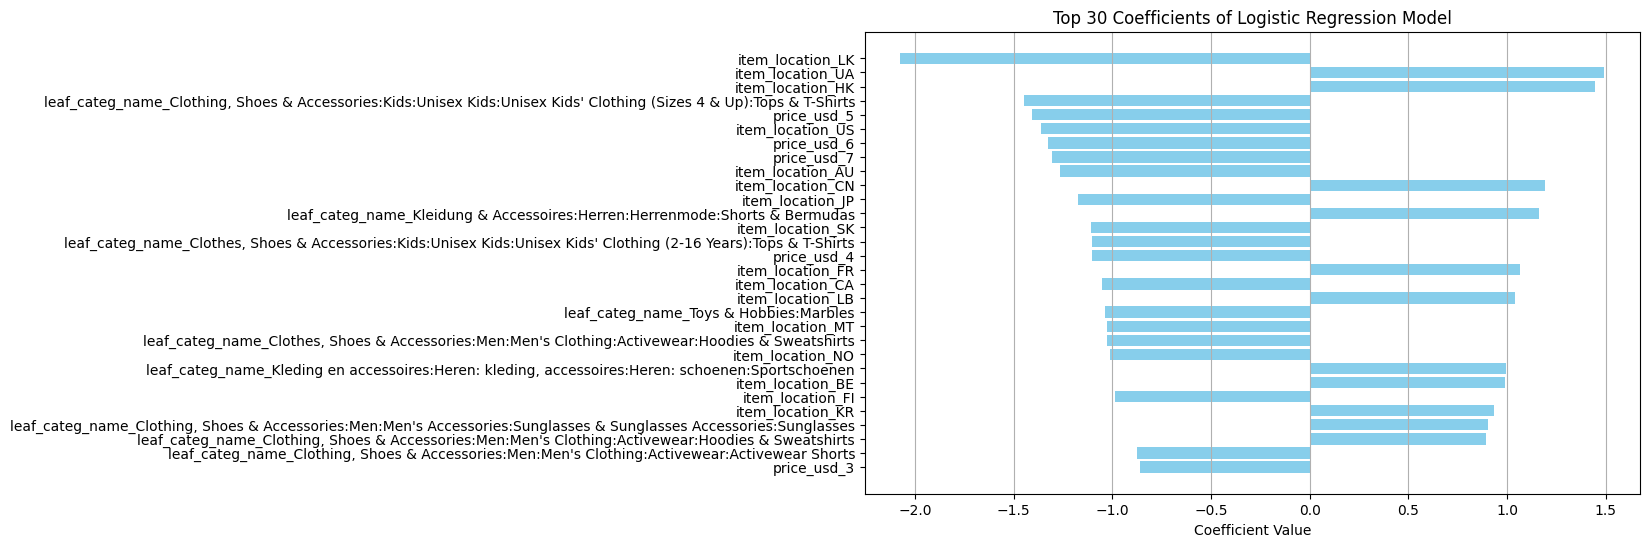

In [67]:

top_n_features = 30
top_feature_indices = np.abs(coefficients).argsort()[-top_n_features:]

top_feature_names = feature_names[top_feature_indices]
top_coefficients = coefficients[top_feature_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_names)), top_coefficients, align='center', color='skyblue')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n_features} Coefficients of Logistic Regression Model')
plt.grid(axis='x')
plt.show()


## Summing up
### I used three different methods trying to calssify the data.  The three of them yielded Surprisingly Similar results (79.9% accuracy) , though using different features of the data in every model. The lack of accuracy in the models, is attributed  also to a similar source, the three of the model had a large amount of instances at FN, meaning, they had difficulties classifying an instance as true although it is. The other way around, FP ,the second and last attribute that effects the lack of accuracy, is much smaller, meaning the model had no trouble detecting a real false instance. In the bottom line, it's not easy to classify correctly a True instance. I believe of course, that with more work, more sophisticated models, or even combination of  some of the models we used, we can derive even better results.